In [1]:
import pandas as pd
import numpy as np
import chess

from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Use grid search to find the best hyperparameters
from sklearn.model_selection import GridSearchCV

In [2]:
# Load and prepare the data
lichess_username = "ritutoshniwal"
file_path = f"../data/raw/games_{lichess_username}.csv"
chess_df = pd.read_csv(file_path)
chess_df = chess_df.dropna()
display(chess_df.head())

,game_id,white_player,black_player,winning_player,move_list
0,UWNtHs0N,ANONYMOUS,ritutoshniwal,ANONYMOUS,e4 e5 Bc4 Nc6 Qh5 h6 Qxf7#
1,vYvlCtTz,ritutoshniwal,ANONYMOUS,ritutoshniwal,e4 c6 Bc4 e5 Qf3 d5 exd5 cxd5 Bxd5 g6 Qxf7#
2,6QuscuXU,ANONYMOUS,ritutoshniwal,ritutoshniwal,d4 d5 f3 Nf6 e4 dxe4 fxe4 Nxe4 Bd3 Bf5 Bxe4 Bx...
3,bPKiMQXh,nelsonyeh9,ritutoshniwal,nelsonyeh9,e4 c5 d4 cxd4 c3 d6 Nf3 dxc3 Nxc3 Nc6 Bc4 Nf6 ...
4,gjic8Xdq,ritutoshniwal,nachory,nachory,d4 d5 Nf3 e6 e3 a6 Bd3 h6 Nbd2 Nf6 O-O Bd6 Qe2...


In [3]:
fresh_chess_board = chess.Board()
# Get all unique characters in fresh_chess_board
unique_characters = list(set(fresh_chess_board.board_fen()))
unique_characters = [char for char in unique_characters if char.isalpha()]
unique_characters.sort()
vocabulary_dict = {char: i+1 for i, char in enumerate(unique_characters)}
vocabulary_dict["EMPTY"] = -1
print(vocabulary_dict)

reverse_vocabulary_dict = {i: char for char, i in vocabulary_dict.items()}
print(reverse_vocabulary_dict)

{'B': 1, 'K': 2, 'N': 3, 'P': 4, 'Q': 5, 'R': 6, 'b': 7, 'k': 8, 'n': 9, 'p': 10, 'q': 11, 'r': 12, 'EMPTY': -1}
{1: 'B', 2: 'K', 3: 'N', 4: 'P', 5: 'Q', 6: 'R', 7: 'b', 8: 'k', 9: 'n', 10: 'p', 11: 'q', 12: 'r', -1: 'EMPTY'}


In [4]:
def convert_chess_board_to_2d_array(chess_board: chess.Board, squeeze: bool = True) -> np.ndarray:
    # Convert chess board to 2D array
    board_2d = []
    for i in range(7, -1, -1):
        row = []
        for j in range(0, 8):
            piece = chess_board.piece_at(i * 8 + j)
            if piece is not None:
                row.append(piece.symbol())
            else:
                row.append(None)
        board_2d.append(row)
    board_2d = np.array(board_2d)
    if squeeze:
        # Reduce to single dimension if squeeze is True
        board_2d = board_2d.reshape(-1)
    return board_2d

# For all values in X, transform string to int using vocabulary_dict
def encode_df(df: pd.DataFrame) -> pd.DataFrame:
    df = df.fillna("EMPTY")
    df = df.map(lambda x: vocabulary_dict[x] if x in vocabulary_dict else x)
    return df

def decode_np_array(np_array: np.ndarray) -> list[str]:
    ret_list = [reverse_vocabulary_dict[i] for i in np_array]
    # If ret_list contains "EMPTY", replace it with None
    ret_list = [None if x == "EMPTY" else x for x in ret_list]
    return ret_list

In [5]:
dataset = []

for _, row in chess_df.iterrows():
    game_id = row.get("game_id")
    white_player = row.get("white_player")
    move_list = row["move_list"].split(" ")
    move_list_length = len(move_list)

    generator_start_index = 0 if white_player == lichess_username else 1

    for i in range(generator_start_index, move_list_length, 2):
        target_move = move_list[i]

        input_sequence = ""
        if i > 0:
            input_sequence = " ".join(move_list[:i])

        board = chess.Board()
        for move in input_sequence.split(" "):
            if move != "":
                board.push_san(move)
        
        board_array = convert_chess_board_to_2d_array(board)
        board_array: list[str] = board_array.tolist()
        # display(board)

        board.push_san(target_move)
        # display(board)
        board_with_target_array = convert_chess_board_to_2d_array(board)
        board_with_target_array: list[str] = board_with_target_array.tolist()

        board_array.insert(0, game_id)
        board_array.extend(board_with_target_array)

        dataset.append(board_array)

dataset_df = pd.DataFrame(dataset)
display(dataset_df.head())

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,128
0,UWNtHs0N,r,n,b,q,k,b,n,r,p,...,P,P,R,N,B,Q,K,B,N,R
1,UWNtHs0N,r,n,b,q,k,b,n,r,p,...,P,P,R,N,B,Q,K,None,N,R
2,UWNtHs0N,r,None,b,q,k,b,n,r,p,...,P,P,R,N,B,None,K,None,N,R
3,vYvlCtTz,r,n,b,q,k,b,n,r,p,...,P,P,R,N,B,Q,K,B,N,R
4,vYvlCtTz,r,n,b,q,k,b,n,r,p,...,P,P,R,N,B,Q,K,None,N,R


In [6]:
# Make last column as target and rest of them as features
# First column is game_id, group by game_id
groups = dataset_df.groupby(0)

model = RandomForestClassifier()
mean_acc = 0
for game_id, group in tqdm(groups):
    game_df = group.drop(columns=[0])
    if len(game_df) < 2:
        continue

    # Make X = first 64 columns of game_df, rest of them as y
    X = game_df.iloc[:, :64]
    y = game_df.iloc[:, -64:]

    X = encode_df(X)
    y = encode_df(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    #calculate accuracy without using any library
    accuracy = (y_pred == y_test).sum() / len(y_test)
    accuracy = accuracy.mean()
    mean_acc += accuracy


mean_acc = mean_acc / len(groups)
print(f"Accuracy = {(mean_acc*100).round()}%")

  0%|          | 0/1853 [00:00<?, ?it/s]

Accuracy = 93.0%


ValueError: multiclass-multioutput is not supported

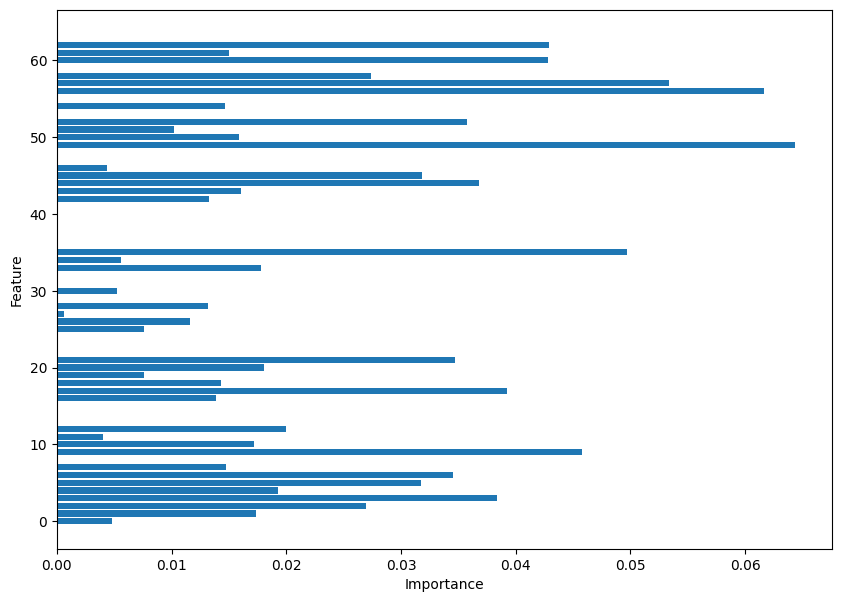

In [9]:
# plot feature importances
feature_importances = model.feature_importances_
plt.figure(figsize=(10, 7))
plt.barh(range(64), feature_importances)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

'BEFORE'

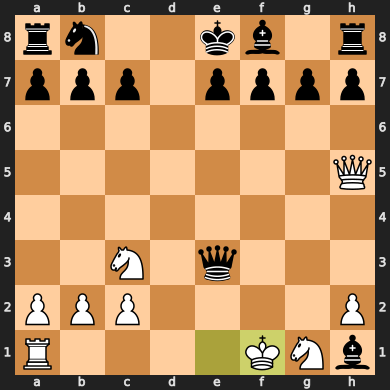

'AFTER'

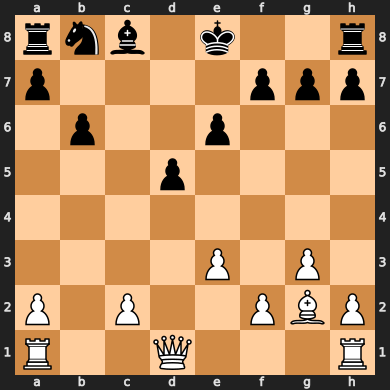

In [ ]:
example_moves = "e4 e5 Nf3 Nc6"
example_board = chess.Board()
for move in example_moves.split(" "):
    if move != "":
        example_board.push_san(move)

display("BEFORE")
display(example_board)

example_board_array = convert_chess_board_to_2d_array(example_board)
example_board_array = example_board_array.tolist()
df = pd.DataFrame([example_board_array])
df = encode_df(df)

pred = model.predict(df)

decoded_pred = decode_np_array(pred[0])
decoded_pred = np.array(decoded_pred).reshape(8, 8)
# Build chess board from decoded_pred

prediction_board = chess.Board()
# Place the pieces on the board according to the board layout
for row, row_pieces in enumerate(decoded_pred):
    for col, piece_symbol in enumerate(row_pieces):
        # Calculate the square index based on row and column
        square = chess.square(col, 7 - row)  # 7 - row because row 0 is the 8th rank in chess
        # Create the piece from the symbol
        if piece_symbol:
            piece = chess.Piece.from_symbol(piece_symbol)
        else:
            piece = None
        # Set the piece on the board
        prediction_board.set_piece_at(square, piece)

display("AFTER")
display(prediction_board)